# Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# reading the csv file
df = pd.read_csv('perrin-freres-champagne-sales.csv')
df

,Month,champagne sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946
...,...,...
100,1972-05,4618
101,1972-06,5312
102,1972-07,4298
103,1972-08,1413


In [3]:
#changing column names for understanding

df.columns = ['Time','sales']
df

,Time,sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946
...,...,...
100,1972-05,4618
101,1972-06,5312
102,1972-07,4298
103,1972-08,1413


In [4]:
# coverting the data type of time column to timeseries
df['Time'] = pd.to_datetime(df['Time'])

df.isnull().sum()

Time     0
sales    0
dtype: int64

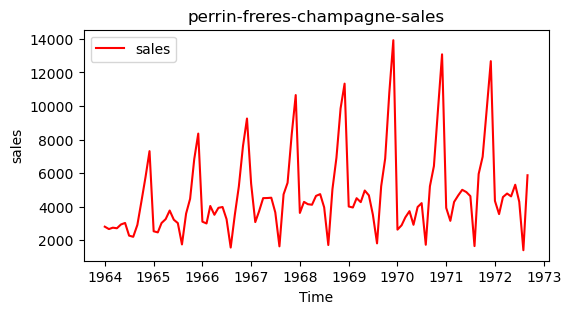

In [5]:
#visualizing the data to observe trend and whether the data is stationary or not
plt.figure(figsize = (6,3))
plt.plot(df['Time'], df['sales'], color='red',label = 'sales')
plt.xlabel('Time')
plt.ylabel('sales')
plt.title('perrin-freres-champagne-sales')
plt.legend()
plt.show()

from the above plot we observe increase in sales at specific intervals. And we can see a positive trend.As the data look to be 
not stationary lets apply statistical test for the dataset.

In [6]:
#Applying adfuller test to verify whether the data is stationary or not.
from statsmodels.tsa.stattools import adfuller
results = adfuller(df['sales'])
print('p-value:',results[1])

p-value: 0.3639157716602462


As the P-value is greater than 0.05 , we accept the null hypothesis that data is not stationary.

Now,by applying differencing and boxcox transformation, converting non-stationary data to stationary is done

In [7]:
#importing boxcox transform and applying it for sales column and we apply differencing to the sales_boxcox column.
from scipy.stats import boxcox
df['sales_boxcox'],lamda = boxcox(df['sales'])
df['sales_stationary'] = df['sales_boxcox'].diff()
df.dropna(inplace = True)

df

,Time,sales,sales_boxcox,sales_stationary
1,1964-02-01,2672,4.588251,-0.015584
2,1964-03-01,2755,4.597409,0.009159
3,1964-04-01,2721,4.593696,-0.003713
4,1964-05-01,2946,4.617329,0.023633
5,1964-06-01,3036,4.626206,0.008877
...,...,...,...,...
100,1972-05-01,4618,4.745779,-0.009953
101,1972-06-01,5312,4.784020,0.038242
102,1972-07-01,4298,4.725845,-0.058175
103,1972-08-01,1413,4.387456,-0.338390


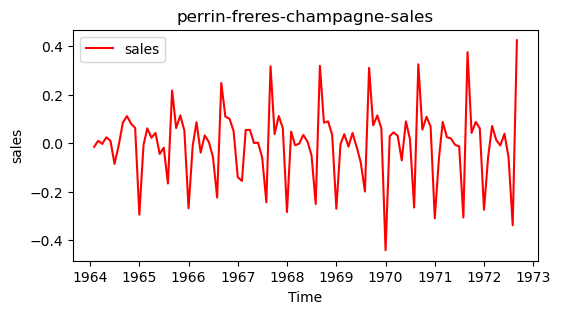

In [8]:
#plotting and visualising the stationary data
plt.figure(figsize = (6,3))
plt.plot(df['Time'], df['sales_stationary'], color='red',label = 'sales')
plt.title('perrin-freres-champagne-sales')
plt.xlabel('Time')
plt.ylabel('sales')
plt.legend()
plt.show()

from the above plot we can observe the data is stationary.lets apply adfuller test again for confirmation

In [9]:
# adfuller test is applied for the stationary data.
from statsmodels.tsa.stattools import adfuller
results = adfuller(df['sales_stationary'])
print('p-value:',results[1])

p-value: 0.000260888771011304


now we got p-value less than 0.05, that means data is stationary.

# order selection 

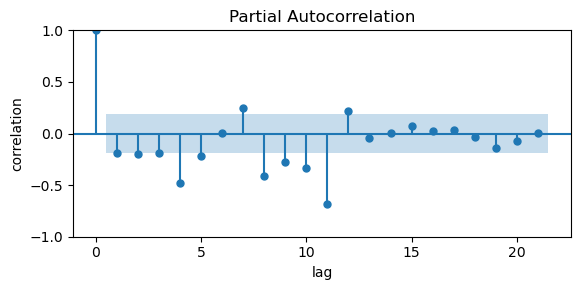

In [10]:
#plot of partial autocorrelation to see the lags
from statsmodels.graphics.tsaplots import plot_pacf
plt.rc('figure',figsize = (6,3))
plot_pacf(df['sales_stationary'])
plt.xlabel('lag')
plt.ylabel('correlation')
plt.tight_layout()
plt.show()

from the plot at lags 4,8,9,10,11 are significant and have strong correlation.
In implementation lets iterate all possible combination of lags.


# Building model

In [11]:
# spliting the data into train and test
train = df.iloc[:-int(len(df)*0.2)]
test = df.iloc[-int(len(df)*0.2):]

#importing AutoReg and ar_select_order
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

#selecting order of lags
ord_sel = ar_select_order(train['sales_stationary'],13)

#Building model and fiting train data for model training
model = AutoReg(train['sales_stationary'], lags = ord_sel.ar_lags).fit()


C:\Users\chaitanya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\chaitanya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\chaitanya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# forecasting

In [12]:
# forecasting the results for test data
forecast_results = list(model.forecast(steps=len(test)))

# as we have forecasted for differenced and box_cox transformed data, we need to apply inverse boxcox to get sales values.
from scipy.special import inv_boxcox
sales_forecasts = []

# iterating over each index 'x' for length of test set.
for x in range(len(test)):
    if x == 0:
        sales_forecast = forecast_results[x] + train['sales_boxcox'].iloc[-1]
    else:
        sales_forecast = forecast_results[x] + sales_forecasts[x-1]

# appending the results to list
    sales_forecasts.append(sales_forecast)
# applying inverse boxcox to forecasted results to get actual sales values.
forecasts = inv_boxcox(sales_forecasts, lamda)

print('sales_forecasts:',forecasts)

sales_forecasts: [ 3006.90433508  3157.70245382  4173.96049975  3032.79255913
  4203.29922055  4356.32041616  1850.26045267  5461.35568387
  7074.14477039 10049.09555133 13220.89228218  4506.62039836
  3109.38838608  3021.29226415  4582.22697868  3164.98005307
  4381.3557767   4570.74069389  1972.0433573   5662.24639394]


C:\Users\chaitanya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\chaitanya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# visualising the forecasts

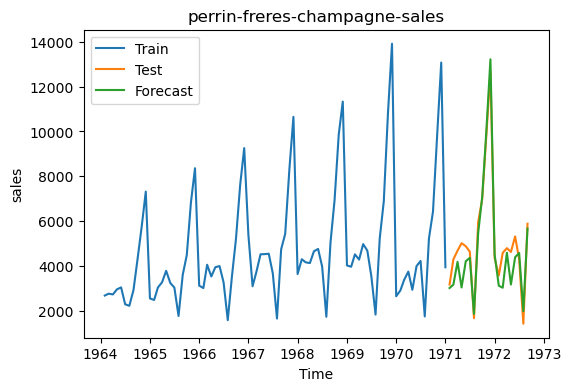

In [13]:
#plot of sales forecast
plt.figure(figsize = (6,4))
plt.plot(train['Time'], train['sales'], label='Train')
plt.plot(test['Time'], test['sales'], label='Test')
plt.plot(test['Time'], forecasts, label='Forecast')
plt.title('perrin-freres-champagne-sales')
plt.xlabel('Time')
plt.ylabel('sales')
plt.legend()
plt.show() 